Régression logistique
===

Cette fois ci, on cherche à prédire une variable qui prend des valeurs dans certaines classes (variable catégorielle) et non pas une valeur précise (variable continue). Malgré le nom de cette technique (régression logistique), on ne fait plus de la régression mais de la classification.

Pour travailler cette nouvelle technique, on utilisera le [dataset](http://data.nantes.fr/donnees/detail/adresses-postales-de-nantes-metropole/) de Nantes Open Data contenant toutes les adresses postales de Nantes Métropole. Notre but ? À partir des coordonnées GPS d'une rue, on cherche à savoir si elle se trouve ou non dans la zone du code postal 44000.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('../data/addresses/train.csv')

- chargez les 10000 première lignes des colonnes `LONG_WGS84` et `LAT_WGS84` dans la variable `X` et les 10000 premières lignes de la colonne `CODE_POSTAL` dans la variable `y`. `y` devra contenir `True` pour les codes postaux à 44000 et `False` pour le reste.

In [3]:
train_df = train_df.iloc[:10000, :]
X, y = (train_df[['LONG_WGS84', 'LAT_WGS84']],
        train_df['CODE_POSTAL'] == 44000)

- standardisez les variables d'entrée, cette fois manuellement plutôt qu'avec `sklearn.preprocessing`

In [4]:
X -= X.mean()
X /= X.std()

- visualisez les données d'entrée. Elles sont 2-dimensionnelles et s'y prêtent bien.

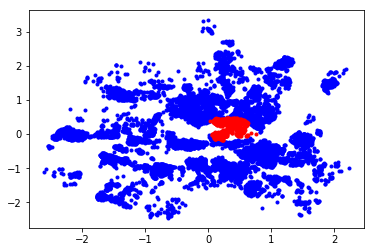

In [5]:
plt.plot(X[~y].iloc[:, 0], X[~y].iloc[:, 1], 'b.')
plt.plot(X[y].iloc[:, 0], X[y].iloc[:, 1], 'r.')
plt.show()

Notre but est donc d'apprendre la zone rouge de manière automatique afin de pouvoir déclarer les GPS qu'elle contient comme étant 44000.

Cette fois-ci, au lieu d'apprendre une fonction de type

$$h_\theta(\text{long}, \text{lat}) = \theta_0 + \theta_1 \times \text{long} + \theta_2 \times \text{lat}$$

comme on l'aurait fait avec une régression linéaire, on va apprendre une fonction de type

$$h_\theta(\text{long}, \text{lat}) = \sigma\left(\theta_0 + \theta_1 \times \text{long} + \theta_2 \times \text{lat}\right)$$

où
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Cette fonction $\sigma$ ressemble à

![The logistic sigmoid function by Qef](files/img/sigmoid.jpeg)

Intuitivement, la différence par rapport à la régression linéaire est que la fonction $\sigma$ va nous permettre d'attribuer une classe à un objet d'entrée en fonction de sa distance avec la frontière linéaire entre les classes.

Cette fois-ci, nous allons exclusivement utiliser scikit-learn et sa classe `sklearn.linear_model.LogisticRegression`.

- à votre avis, pourquoi la régression logistique est classée dans les modèles linéaires alors qu'elle contient une non-linéarité ?

Car sa frontière de décision est linéaire.

- pensez vous qu'une fonction linéaire puisse apprendre la frontière de délimitation des classes ?
- si non, comment modifier le modèle pour qu'il y parvienne ?

Comme dit ci-dessus, la frontière de décision est linéaire. Or, nous avons besoin d'apprendre une forme beaucoup plus complexe qu'une droite (une ellipse déformée) pour correctement modéliser les données. On peut ajouter des features polynomiales pour donner au modèle la capacité d'apprendre des fontières de décision plus complexe.

- utilisez le modèle de régression logistique de `sklearn` avec la modification que vous envisagez

In [6]:
# we'll needs polynomial features, sklearn has a handy tool for that
# 1, a, b, a^2, ab, b^2
poly = sklearn.preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# poly already adds the bias, so we set fit_intercept to False
logreg = sklearn.linear_model.LogisticRegression(fit_intercept=False)
logreg.fit(X_poly, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Plotter le résultat
---

Nous pouvons maintenant visualiser les résultats du modèle.

- réaffichez le plot initial des rues dans le code postal 44000
- affichez dans un plot à côté, qui partage la même série bleue (les rues pas 44000), les résultats du modèle

Que penser du résultat ?

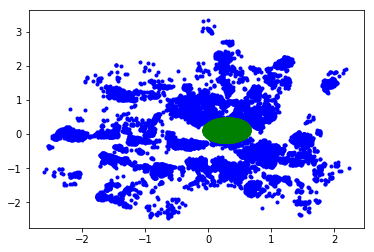

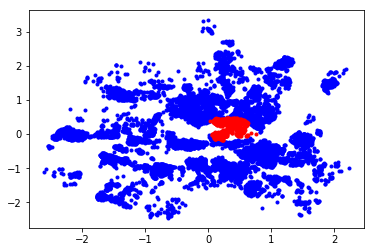

In [7]:
# let's predict & plot everything on a square to see what's the
# classification frontier
x_min, y_min = X.min() - .5
x_max, y_max = X.max() + .5
step = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))
coords = np.c_[xx.ravel(), yy.ravel()]

z = logreg.predict(poly.fit_transform(coords))

# plot the output when it's true for our square
plt.plot(X[~y].iloc[:, 0], X[~y].iloc[:, 1], 'b.')
plt.plot(coords[z, 0], coords[z, 1], 'g.')
plt.show()

# replot the first plot for comparison
plt.plot(X[~y].iloc[:, 0], X[~y].iloc[:, 1], 'b.')
plt.plot(X[y].iloc[:, 0], X[y].iloc[:, 1], 'r.')
plt.show()

Modification de la complexité du modèle
---

- faites varier l'ordre des polynomes
- que constatez-vous ?
- si cette variation dégrade les résultats, pourrait-elle quand même être utile dans ce contexte ?

On constate parfois que le modèle apprend des zones de prédiction complexes hors de la zone qui nous intéresse. Cette variation dans l'expressivité du modèle pourrait être intéressante pour réussir à classifier plus de code postaux que simplement le 44000 par exemple, quand les frontières de décision deviendraient plus complexes.

Annexe : détails sur la régression logistique
---

Comme pour la régression linéaire, nous aurons besoin d'une fonction de coût et d'une méthode d'optimisation pour calculer la régression logistique. La méthode ne change pas, seule la fonction de coût et sa dérivée sont à re-étudier :

### Fonction de coût

De manière générale, on peut écrire une fonction de coût comme :

$$
J(\theta) = \frac{1}{m}\sum^m_{i=1}\text{Cost}\left(h_\theta(x^{(i)}), y^{(i)}\right)
$$

avec $\text{Cost}$ à définir. Pour la régression logistique, on utilise
$$
\begin{cases} 
 -\log(h_\theta(x)) & \text{si } y = 1 \\
 -\log(1 - h_\theta(x)) & \text{si } y = 0 \\
\end{cases}
$$

On peut réécrire cette fonction comme suit :

$$
\text{Cost}\left(h_\theta(x^{(i)}), y^{(i)}\right) = -y\log(h_\theta(x)) -(1 - y)\log(1 - h_\theta(x))
$$

### Dérivée de la fonction de coût

Nous donnerons ici seulement la forme finale, qui ne diffère de celle de la régression linéaire que pour la nature de l'hypothèse $h$ (avec sa fonction $\sigma$ additionnelle) :

$$
\frac{\partial}{\partial\theta}J(h\theta) = \frac{\partial}{\partial\theta} \frac{1}{m}\sum^m_{i=1}\left(h_\theta(X^{(i)}) - y^{(i)}\right)X^{(i)}
$$

L'implémentation est la même que celle que l'on a faite pour la régression linéaire, à la fonction de coût et à cette dérivée près. Essayez de la compléter pour solidifier vos bases !